In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
import altair as alt

In [53]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


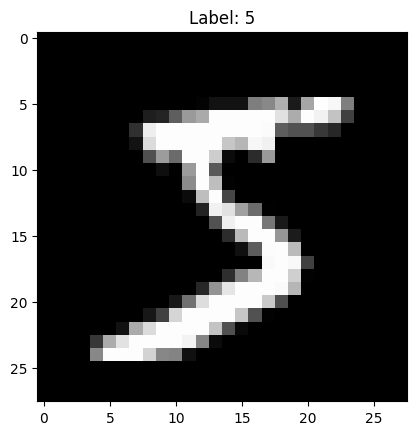

In [54]:
# Load MNIST without transforming to tensors
train_dataset_pic = datasets.MNIST(root='./data', train=True, download=True)

# Get the first image and its label
image, label = train_dataset_pic[0]  

# Display the image and label
plt.imshow(image, cmap='gray')  # Use grayscale colormap for MNIST
plt.title(f'Label: {label}')
plt.show()

In [55]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [56]:
# Transformations 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 

#make the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [57]:
# init the nn class with an init function and a forward pass
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512) # Input: 28x28 image, Hidden layer: 512 neurons
        self.fc2 = nn.Linear(512, 10)   # Output: 10 classes (digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image 
        x = F.relu(self.fc1(x)) #what should this be if F is wrong?
        x = self.fc2(x)
        return x


In [58]:
# establish the model, loss function and the optim (brett used Adam so lets go with that one. the list is insanely long to choose from)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [60]:
# Training loop
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_losses.append(train_loss)
        _, predicted = torch.max(output.data, 1)
        train_accuracy = (predicted == target).sum().item() / len(train_dataset) * 100
        train_accuracies.append(train_accuracy)

    #the song says "print out whats happenin'"
    print(f'Epoch {epoch}: Loss: {loss.item():.4f}')

Epoch 0: Loss: 0.1271
Epoch 1: Loss: 0.0126
Epoch 2: Loss: 0.1201
Epoch 3: Loss: 0.0664
Epoch 4: Loss: 0.0142
Epoch 5: Loss: 0.1084
Epoch 6: Loss: 0.0037
Epoch 7: Loss: 0.0093
Epoch 8: Loss: 0.0058
Epoch 9: Loss: 0.0558


In [72]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():  # No gradients needed during evaluation
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss) #for display 
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy) #for display 

print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Test Loss: 0.0012, Accuracy: 98.01%


In [73]:
train_losses = train_losses[:10]
train_accuracies = train_accuracies[:10]
test_losses = test_losses[:10]
test_accuracies = test_accuracies[:10]
print(train_losses)
print(train_accuracies)
print(test_losses)
print(test_accuracies)

[2.309278726577759, 2.2340774536132812, 2.168731689453125, 2.090459108352661, 2.0005297660827637, 1.9324040412902832, 1.7969869375228882, 1.676148533821106, 1.6972265243530273]
[0.008333333333333333, 0.018333333333333333, 0.03666666666666667, 0.045, 0.05666666666666667, 0.07166666666666667, 0.07166666666666667, 0.06833333333333333, 0.06]
[0.0011679290855385262, 0.0011679290855385262]
[98.01, 98.01]


In [74]:
# Create Altair charts for loss and accuracy
loss_chart = alt.Chart(pd.DataFrame({
    'Epoch': range(10),
    'Training Loss': train_losses,
    'Test Loss': test_losses
})).mark_line().encode(
    x='Epoch',
    y='Loss',
    color='Type:N',
    tooltip=['Epoch', 'Loss', 'Type']
).properties(
    title='Training and Test Loss'
).interactive()

accuracy_chart = alt.Chart(pd.DataFrame({
    'Epoch': range(10),
    'Training Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies
})).mark_line().encode(
    x='Epoch',
    y='Accuracy',
    color='Type:N',
    tooltip=['Epoch', 'Accuracy', 'Type']
).properties(
    title='Training and Test Accuracy'
).interactive()

ValueError: All arrays must be of the same length